In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt

# --- 中文顯示設定 ---
# 加上這兩行來正常顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 指定支援中文的字體
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題
# ---

# ... 接著是您其他的 import 和程式碼 ...
# import os
# import numpy as np
# from PIL import Image

顯示圖片: 0001TP_009480.png
對應遮罩: 0001TP_009480_L.png


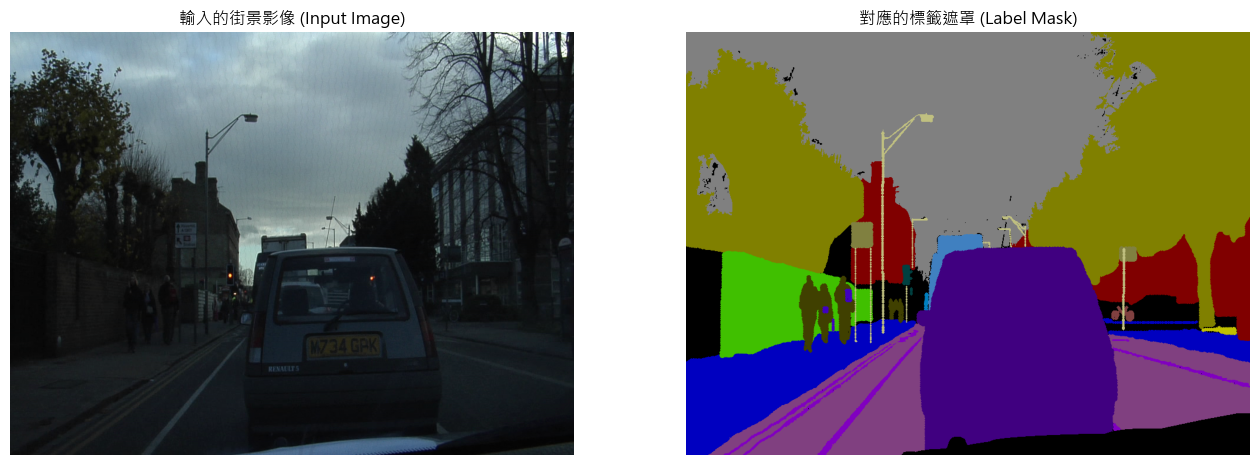

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# --- 步驟 1: 探索與視覺化 CamVid 資料 ---

# 【請確認】根據您解壓縮後的路od徑，設定圖片和標籤遮罩的資料夾路徑
# 通常 Kaggle 下載的 CamVid 資料集結構是這樣的
IMAGE_DIR = './camvid/train/'
LABEL_DIR = './camvid/train_labels/'

# 取得所有圖片的檔名
image_filenames = sorted(os.listdir(IMAGE_DIR))
label_filenames = sorted(os.listdir(LABEL_DIR))

# --- 挑選一張圖片來視覺化 ---
example_index = 5 # 您可以更改這個索引來看不同的圖片
example_image_filename = image_filenames[example_index]
example_label_filename = label_filenames[example_index]

print(f"顯示圖片: {example_image_filename}")
print(f"對應遮罩: {example_label_filename}")

# 組合出完整的檔案路徑
image_path = os.path.join(IMAGE_DIR, example_image_filename)
label_path = os.path.join(LABEL_DIR, example_label_filename)

# 使用 PIL 函式庫讀取圖片
input_image = Image.open(image_path).convert("RGB")
label_mask = Image.open(label_path) # 標籤遮罩直接讀取，不轉換模式

# --- 視覺化 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(input_image)
ax1.set_title("輸入的街景影像 (Input Image)")
ax1.axis('off')

ax2.imshow(label_mask)
ax2.set_title("對應的標籤遮罩 (Label Mask)")
ax2.axis('off')

plt.show()

--- 建立的顏色 -> ID 映射字典 (部分範例) ---
{(64, 128, 64): 0, (192, 0, 128): 1, (0, 128, 192): 2, (0, 128, 64): 3, (128, 0, 0): 4}


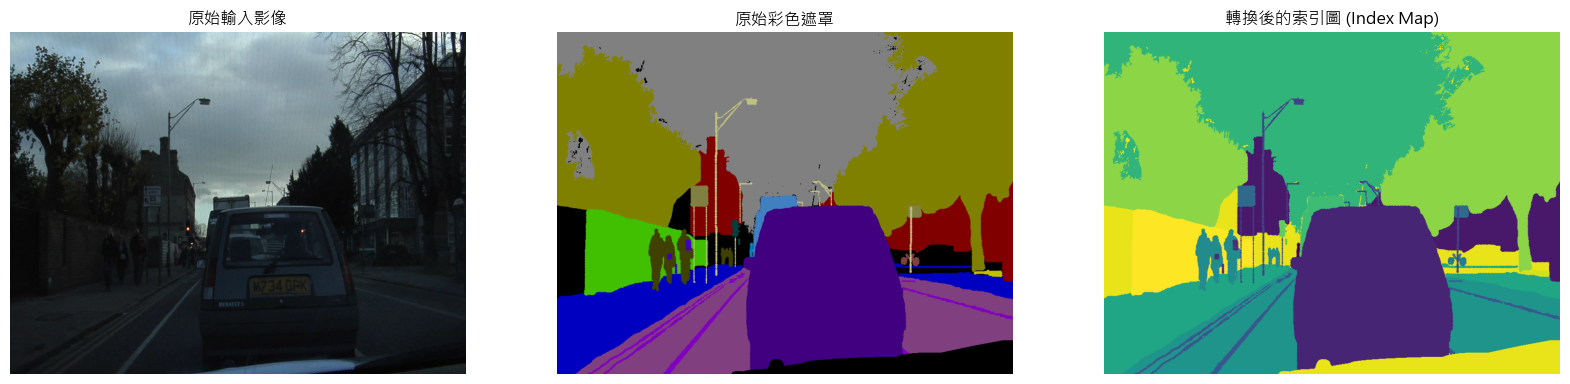


--- 驗證轉換後的索引圖 ---
索引圖的形狀: (720, 960)
索引圖中包含的獨立像素值 (類別 ID): 
[ 2  4  5  6  8 10 12 14 16 17 19 21 22 24 26 29 30 31]


In [7]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- 步驟 1.2: 實作從 RGB 遮罩到索引圖的轉換 ---

# 【請確認】路徑是否正確
CAMVID_DIR = './camvid/'
CLASS_DICT_PATH = os.path.join(CAMVID_DIR, 'class_dict.csv')
IMAGE_DIR = os.path.join(CAMVID_DIR, 'train/')
LABEL_DIR = os.path.join(CAMVID_DIR, 'train_labels/')

# 1. 讀取 class_dict.csv 並建立顏色映射字典
class_df = pd.read_csv(CLASS_DICT_PATH)

# 建立 (R, G, B) -> class_id 的字典
color_to_id = {}
for index, row in class_df.iterrows():
    # 將顏色值 (r, g, b) 組成一個元組 (tuple) 作為字典的鍵
    color_tuple = (row['r'], row['g'], row['b'])
    # 字典的值是這個類別的索引 (DataFrame 的 index)
    color_to_id[color_tuple] = index

print("--- 建立的顏色 -> ID 映射字典 (部分範例) ---")
print({k: color_to_id[k] for k in list(color_to_id)[:5]}) # 只印出前 5 個


# 2. 定義轉換函式
def rgb_mask_to_index_map(mask_image, color_map):
    """
    將一張彩色的 PIL.Image 遮罩圖，轉換成單通道的 NumPy 索引圖。
    """
    # 將 PIL Image 轉換為 NumPy 陣列，形狀為 (H, W, 3)
    rgb_mask = np.array(mask_image)
    
    # 建立一個空白的單通道索引圖，形狀為 (H, W)
    index_map = np.zeros(rgb_mask.shape[:2], dtype=np.uint8)
    
    # 遍歷顏色字典，進行查表和填色
    for color_rgb, class_id in color_map.items():
        # 找出彩色遮罩中，所有等於目前 'color_rgb' 的像素位置
        # np.all(axis=2) 是在第三個維度 (RGB通道) 上進行比較
        matching_pixels = np.all(rgb_mask == color_rgb, axis=2)
        
        # 在我們的索引圖上，將這些位置的像素值，填上對應的 class_id
        index_map[matching_pixels] = class_id
        
    return index_map


# 3. 實際測試與視覺化
image_filenames = sorted(os.listdir(IMAGE_DIR))
example_filename = image_filenames[5]

image_path = os.path.join(IMAGE_DIR, example_filename)
label_path = os.path.join(LABEL_DIR, example_filename.replace('.png', '_L.png'))

input_image = Image.open(image_path)
color_mask = Image.open(label_path)

# 執行轉換！
index_map_mask = rgb_mask_to_index_map(color_mask, color_to_id)


# --- 視覺化轉換結果 ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.imshow(input_image)
ax1.set_title("原始輸入影像")
ax1.axis('off')

ax2.imshow(color_mask)
ax2.set_title("原始彩色遮罩")
ax2.axis('off')

ax3.imshow(index_map_mask, cmap='viridis') # 使用 'viridis' 色彩映射來顯示索引差異
ax3.set_title("轉換後的索引圖 (Index Map)")
ax3.axis('off')

plt.show()

print("\n--- 驗證轉換後的索引圖 ---")
print(f"索引圖的形狀: {index_map_mask.shape}")
print(f"索引圖中包含的獨立像素值 (類別 ID): \n{np.unique(index_map_mask)}")

In [31]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from PIL import Image
import os
import torchvision.transforms as T

# --- 步驟 2: 實作 CamVidDataset 類別 ---

# --- 【更新後】的 CamVidDataset ---
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, class_dict_path, transforms=None):
        super().__init__()
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        
        # 【關鍵修正】我們分別讀取 image 和 label 的檔名列表，並排序
        self.image_names = sorted(os.listdir(self.image_dir))
        self.mask_names = sorted(os.listdir(self.label_dir))
        
        # 讀取 class_dict.csv 並建立顏色映射字典 (這部分不變)
        class_df = pd.read_csv(class_dict_path)
        self.color_map = {}
        for index, row in class_df.iterrows():
            color_tuple = (row['r'], row['g'], row['b'])
            self.color_map[color_tuple] = index
            
    def __len__(self):
        return len(self.image_names)

    # --- 【更新後】的 CamVidDataset __getitem__ 方法 ---
    def __getitem__(self, idx):
        # 取得檔名與路徑
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, image_name.replace('.png', '_L.png'))

        # 讀取圖片和彩色遮罩
        image = Image.open(image_path).convert("RGB")
        color_mask = Image.open(label_path)
        
        # 【關鍵修正】在轉換為索引圖之前，先將 image 和 mask 的尺寸統一
        # 我們將使用 256x256
        resize_transform = T.Resize((256, 256))
        image = resize_transform(image)
        
        # 對於 mask，我們必須使用 NEAREST 插值法，避免產生不存在的類別 ID
        mask_resize_transform = T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST)
        color_mask = mask_resize_transform(color_mask)

        # 將彩色遮罩轉換為索引圖 (這部分邏輯不變)
        rgb_mask_array = np.array(color_mask)
        index_map = np.zeros(rgb_mask_array.shape[:2], dtype=np.uint8)
        for color_rgb, class_id in self.color_map.items():
            matching_pixels = np.all(rgb_mask_array == color_rgb, axis=2)
            index_map[matching_pixels] = class_id
        
        # 轉換為 Tensor
        if self.transforms:
            image = self.transforms(image) # 此處的 transforms 主要是 ToTensor 和 Normalize
        
        mask = torch.from_numpy(index_map).long()
        
        return image, mask

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 步驟 3: 建立 U-Net 模型 ---

class DoubleConv(nn.Module):
    """(卷積 => 批次標準化 => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            # 第一層卷積
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), # 批次標準化
            nn.ReLU(inplace=True), # ReLU 激活函數
            # 第二層卷積
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """下採樣模組：最大池化 + 雙層卷積"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), # 最大池化層，將圖片尺寸減半
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """上採樣模組：上採樣 + 跳躍連接 + 雙層卷積"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # 選擇上採樣的方式
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # 【關鍵修正】這裡的輸入通道數，應該是上採樣後的通道數(in_channels)
            # 加上跳躍連接的通道數(out_channels)，才是在 cat 之後的總通道數
            self.conv = DoubleConv(in_channels + out_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            # ConvTranspose2d 的輸出通道是 in_channels // 2，
            # 跳躍連接的通道數也是 in_channels // 2，
            # 所以 cat 之後的總通道數正好是 in_channels
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 是來自上一層 (更深層) 的特徵圖
        # x2 是來自左側編碼器對應層的「跳躍連接 (Skip Connection)」特徵圖
        x1 = self.up(x1) # 對 x1 進行上採樣，使其尺寸與 x2 相同

        # 【關鍵】將跳躍連接的特徵圖 x2 與上採樣後的特徵圖 x1 在通道維度上拼接
        x = torch.cat([x2, x1], dim=1)
        
        # 進行雙層卷積
        return self.conv(x)

class OutConv(nn.Module):
    """輸出層模組"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # 使用 1x1 的卷積核來將特徵圖的通道數調整為最終的類別數
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels # 輸入圖片的通道數 (灰階=1, 彩色=3)
        self.n_classes = n_classes   # 輸出的類別數 (二元分割=1)

        # --- 編碼器 (Encoder)，U的左半邊，負責特徵提取與下採樣 ---
        self.inc = DoubleConv(n_channels, 64)   # 輸入層
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # --- 解碼器 (Decoder)，U的右半邊，負責特徵融合與上採樣 ---
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes) # 輸出層

    def forward(self, x):
        # --- Encoder Path ---
        x1 = self.inc(x)     # 儲存第一層的輸出，用於最後的跳躍連接
        x2 = self.down1(x1)  # 儲存第二層的輸出
        x3 = self.down2(x2)  # ...
        x4 = self.down3(x3)
        x5 = self.down4(x4)  # 進入 U 的最底層
        
        # --- Decoder Path ---
        # 將底層特徵 x5 和 x4 的跳躍連接融合
        x = self.up1(x5, x4) 
        # ... 逐層向上融合 ...
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # --- Final Output ---
        logits = self.outc(x)
        return logits

In [33]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import pandas as pd
import numpy as np

# --- 步驟 4: 訓練與驗證 U-Net 模型 ---

# --- 1. 設定參數與路徑 ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4 # 根據您的 GPU 記憶體調整
EPOCHS = 20 # 您可以從 20 個 epoch 開始
LR = 1e-3
CAMVID_DIR = './camvid/'
CLASS_DICT_PATH = os.path.join(CAMVID_DIR, 'class_dict.csv')
IMAGE_DIR = os.path.join(CAMVID_DIR, 'train/')
LABEL_DIR = os.path.join(CAMVID_DIR, 'train_labels/')

# --- 2. 準備資料 ---
# 影像的 Transforms
transforms = T.Compose([
    T.Resize((256, 256)), # 將圖片縮放到一個固定尺寸
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 使用 ImageNet 的標準化參數
])

full_dataset = CamVidDataset(
    image_dir=IMAGE_DIR, 
    label_dir=LABEL_DIR,
    class_dict_path=CLASS_DICT_PATH,
    transforms=transforms
)

# 分割訓練集和驗證集
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. 初始化模型、損失函數、優化器 ---
# 取得類別總數 (例如 CamVid 有 32 個類別)
num_classes = len(pd.read_csv(CLASS_DICT_PATH))

# n_channels=3 因為輸入是 RGB 彩色圖
# n_classes=num_classes 因為是多類別分割
model = UNet(n_channels=3, n_classes=num_classes).to(DEVICE)

# 【關鍵】多類別分割使用 CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(f"使用的裝置: {DEVICE}")
print(f"訓練集大小: {len(train_dataset)}")
print(f"驗證集大小: {len(val_dataset)}")
print(f"總類別數: {num_classes}")

# --- 4. 訓練與驗證迴圈 ---
for epoch in range(EPOCHS):
    model.train()
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE) # masks 的 shape 是 [B, H, W]
        
        outputs = model(images) # outputs 的 shape 是 [B, C, H, W]
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 驗證 (這裡只計算 loss 作為參考，計算多類別 IoU/Dice 較複雜)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {loss.item():.4f}, " # 印出最後一個 batch 的 loss
          f"Val Loss: {val_loss/len(val_loader):.4f}")

print("\n訓練完成!")

使用的裝置: cuda
訓練集大小: 295
驗證集大小: 74
總類別數: 32
Epoch 1/20, Train Loss: 0.8699, Val Loss: 1.2280
Epoch 2/20, Train Loss: 1.1105, Val Loss: 1.6414
Epoch 3/20, Train Loss: 0.6233, Val Loss: 0.8246
Epoch 4/20, Train Loss: 1.1903, Val Loss: 1.2849
Epoch 5/20, Train Loss: 0.5726, Val Loss: 0.6837
Epoch 6/20, Train Loss: 0.7126, Val Loss: 0.7569
Epoch 7/20, Train Loss: 0.8280, Val Loss: 0.6330
Epoch 8/20, Train Loss: 0.7413, Val Loss: 0.6241
Epoch 9/20, Train Loss: 0.5067, Val Loss: 0.5883
Epoch 10/20, Train Loss: 0.6627, Val Loss: 0.6355
Epoch 11/20, Train Loss: 0.5607, Val Loss: 0.6082
Epoch 12/20, Train Loss: 0.3876, Val Loss: 0.6220
Epoch 13/20, Train Loss: 0.6366, Val Loss: 0.7564
Epoch 14/20, Train Loss: 0.9844, Val Loss: 0.5277
Epoch 15/20, Train Loss: 0.5042, Val Loss: 0.5007
Epoch 16/20, Train Loss: 0.9198, Val Loss: 0.4974
Epoch 17/20, Train Loss: 0.5147, Val Loss: 0.4643
Epoch 18/20, Train Loss: 0.5951, Val Loss: 0.4635
Epoch 19/20, Train Loss: 0.5154, Val Loss: 0.4710
Epoch 20/20, Trai


--- 顯示模型在驗證集上的預測結果 ---


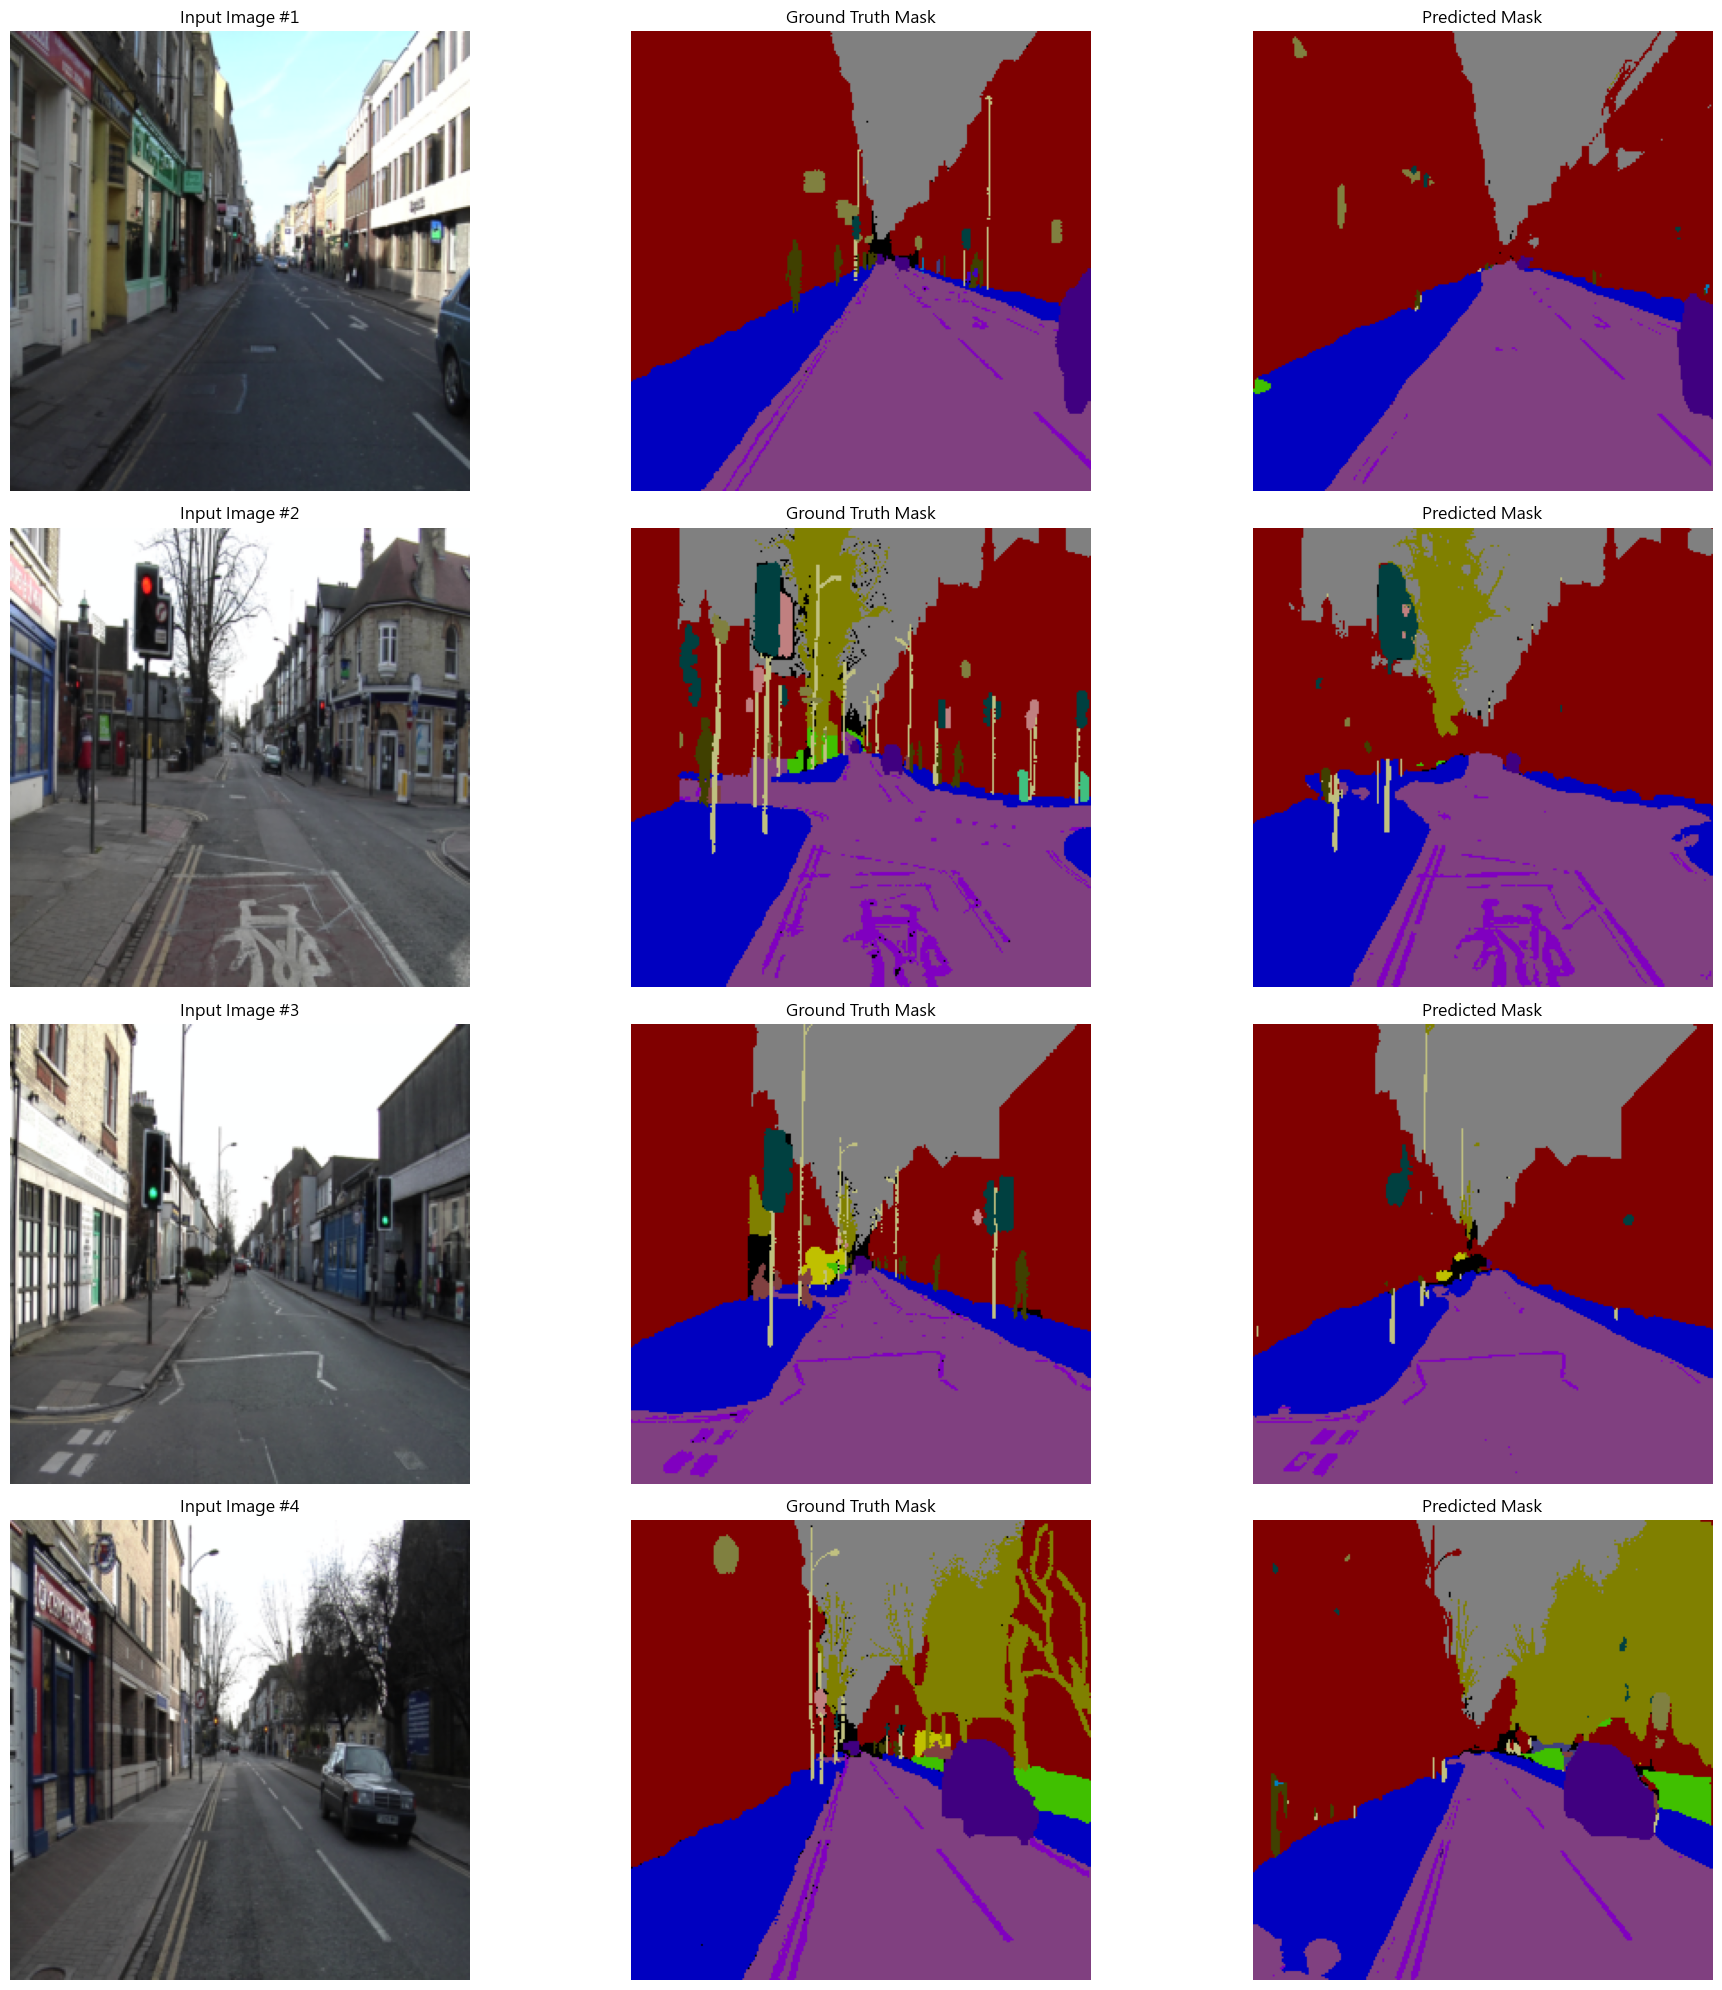

In [34]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- 步驟 5: 預測與視覺化結果 ---

# --- 1. 準備反向翻譯的「ID -> 顏色」字典 ---
CLASS_DICT_PATH = os.path.join(CAMVID_DIR, 'class_dict.csv')
class_df = pd.read_csv(CLASS_DICT_PATH)

id_to_color = {}
for index, row in class_df.iterrows():
    id_to_color[index] = (row['r'], row['g'], row['b'])

# --- 2. 定義從索引圖轉換回彩色圖的函式 ---
def index_map_to_rgb(index_map, color_map):
    """將單通道的 NumPy 索引圖，轉換成彩色的 PIL.Image 圖片。"""
    # 建立一個空白的 RGB 圖片 (H, W, 3)
    rgb_map = np.zeros((index_map.shape[0], index_map.shape[1], 3), dtype=np.uint8)
    
    # 遍歷顏色字典，進行查表和填色
    for class_id, color_rgb in color_map.items():
        # 找出索引圖中，所有等於目前 class_id 的像素位置
        matching_pixels = (index_map == class_id)
        # 在 RGB 圖片上，將這些位置的像素，填上對應的顏色
        rgb_map[matching_pixels] = color_rgb
        
    return Image.fromarray(rgb_map)

# --- 3. 進行預測與視覺化 ---
print("\n--- 顯示模型在驗證集上的預測結果 ---")

# 從驗證集中取出一批資料
images, masks = next(iter(val_loader))
images = images.to(DEVICE)

# 讓模型進行預測
model.eval()
with torch.no_grad():
    outputs = model(images) # outputs shape: [B, C, H, W]

# 使用 argmax 找出每個像素預測分數最高的類別 ID，得到預測的索引圖
# dim=1 是在通道維度上操作
pred_masks = torch.argmax(outputs, dim=1).cpu().numpy() # Shape: [B, H, W]

# 將 PyTorch Tensor 格式的輸入影像和真實遮罩，也轉回 NumPy 格式以便繪圖
images_np = images.cpu().numpy()
masks_np = masks.cpu().numpy()

# --- 繪製結果 ---
batch_size_to_show = min(BATCH_SIZE, 4) # 最多顯示 4 張圖
plt.figure(figsize=(20, 5 * batch_size_to_show))

for i in range(batch_size_to_show):
    # --- 原始影像 ---
    ax = plt.subplot(batch_size_to_show, 3, i * 3 + 1)
    # 將標準化後的 Tensor 轉回可顯示的格式
    img_display = np.transpose(images_np[i], (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)
    ax.imshow(img_display)
    ax.set_title(f"Input Image #{i+1}")
    ax.axis('off')

    # --- 真實遮罩 ---
    ax = plt.subplot(batch_size_to_show, 3, i * 3 + 2)
    true_mask_rgb = index_map_to_rgb(masks_np[i], id_to_color)
    ax.imshow(true_mask_rgb)
    ax.set_title("Ground Truth Mask")
    ax.axis('off')

    # --- 模型預測遮罩 ---
    ax = plt.subplot(batch_size_to_show, 3, i * 3 + 3)
    pred_mask_rgb = index_map_to_rgb(pred_masks[i], id_to_color)
    ax.imshow(pred_mask_rgb)
    ax.set_title("Predicted Mask")
    ax.axis('off')

plt.tight_layout()
plt.show()